# Testing of trained models


In [1]:
from pettingzoo.utils import BaseWrapper
from sb3_contrib import MaskablePPO
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import plotly.express as px


import glob
import os

In [2]:
class SB3ActionMaskWrapper(BaseWrapper):
    """Wrapper to allow PettingZoo environments to be used with SB3 illegal action masking."""

    def reset(self, seed=None, options=None):
        """Gymnasium-like reset function which assigns obs/action spaces to be the same for each agent.

        This is required as SB3 is designed for single-agent RL and doesn't expect obs/action spaces to be functions
        """
        super().reset()

        # Strip the action mask out from the observation space
        self.observation_space = super().observation_space(self.possible_agents[0])
        self.action_space = super().action_space(self.possible_agents[0])

        # Return initial observation, info (PettingZoo AEC envs do not by default)
        return self.observe(self.agent_selection), {}

    def step(self, action):
        """Gymnasium-like step function, returning observation, reward, termination, truncation, info."""
        super().step(action)
        return super().last()

    def observe(self, agent):
        """Return only raw observation, removing action mask."""
        return super().observe(agent)

    def action_masks(self):
        """Separate function used in order to access the action mask."""
        return self.get_action_mask()

BLABLALBA scopa_v0*.zip

In [3]:
try:
    latest_policy = max(
        glob.glob("C:/Users/aless/Repos/Rug/P2/ScopAI/ScopaAI_ToM/scopa_v*.zip"), key=os.path.getctime
    )
    print(f"Loading policy: {latest_policy}")
except ValueError:
    print("Policy not found.")
    quit(0)
    

model = MaskablePPO.load(latest_policy)

Loading policy: C:/Users/aless/Repos/Rug/P2/ScopAI/ScopaAI_ToM\scopa_v0_2M_20250117-014602.zip


In [4]:
observation_space = np.random.choice([0, 1], size=(3, 40), p=[0.7, 0.3])
action_space = np.random.choice([0, 1], size=(40,), p=[0.7, 0.3])

model.predict(observation_space, action_masks=action_space)

(array(28, dtype=int64), None)

In [5]:

history = []

for i in tqdm(range(70000)):
    observation_space = np.random.choice([0, 1], size=(3, 40), p=[0.7, 0.3])
    action_space = np.random.choice([0, 1], size=(40,), p=[0.7, 0.3])
    
    play = model.predict(observation_space, action_masks=action_space)[0]

    history.append(play)




100%|██████████| 70000/70000 [01:15<00:00, 923.45it/s] 


In [8]:
def preload_card_images(image_folder = 'C:/Users/aless/Repos/Rug/P2/ScopAI/ScopaAI_ToM/res/cards', scale_factor=0.1):
    """
    Preload all card images and scale them down dramatically to save resources.
    Args:
        image_folder (str): Path to folder containing card images.
        scale_factor (float): Factor by which to scale down images.
    Returns:
        dict: Dictionary mapping card indices to scaled-down images.
    """
    card_images = {}
    for filename in os.listdir(image_folder):
        if filename.endswith(".png"):
            # Extract rank and suit from filename
            card_name = filename.split(".")[0]  # Remove extension
            rank, suit = card_name.split("_of_")
            
            # Map suit to its corresponding value
            suit_values = {"diamonds": 30, "clubs": 20, "spades": 10, "hearts": 0}
            suit_value = suit_values[suit]

            if rank == "jack":
                rank = 8
            elif rank == "queen":
                rank = 9
            elif rank == "king":
                rank = 10
            elif rank == "ace":
                rank = 1
            
            # Calculate card index based on the new rule
            card_index = int(rank) + suit_value - 1
            
            # Load and scale down image
            image = Image.open(os.path.join(image_folder, filename))
            new_size = (int(image.width * scale_factor), int(image.height * scale_factor))
            scaled_image = image.resize(new_size)
            
            # Add to dictionary
            card_images[card_index] = scaled_image
    return card_images

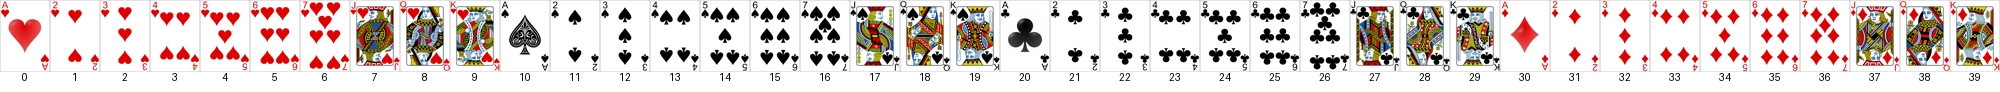

In [45]:
cards = preload_card_images()
# Create a horizontal grid of card images
grid_width = len(cards)
grid_height = 1
card_width, card_height = next(iter(cards.values())).size

# Create a new image with a white background
grid_image = Image.new("RGBA", (grid_width * card_width, grid_height * card_height + 20), (255, 255, 255, 255))
draw = ImageDraw.Draw(grid_image)


# Paste each card image into the grid and add their index below
for i, (index, card_image) in enumerate(dict(sorted(cards.items())).items()):
    grid_image.paste(card_image, (i * card_width, 0))
    draw.text((i * card_width + card_width // 2, card_height + 5), str(index), fill="black", anchor="mm")

# Display the grid image
grid_image

In [ ]:
px.histogram(history, marginal="violin")